# Analyse du Modèle d'Estimation Immobilière

## Introduction

Dans le cadre du développement d'un modèle d'estimation des prix immobiliers, nous avons procédé à une évaluation comparative de plusieurs algorithmes d'apprentissage automatique. Notre approche méthodologique s'est déroulée en plusieurs étapes :

### Méthodologie de Sélection
1. Établissement d'un benchmark initial avec un DummyRegressor pour établir une référence de performance minimale
2. Évaluation comparative de plusieurs modèles :
  * Random Forest
  * Support Vector Machine (SVM)
  * XGBoost
  * Gradient Boosting

### Résultats de la Sélection
* Le Gradient Boosting s'est distingué comme le modèle le plus performant
* Une phase d'optimisation légère a permis d'affiner ses hyperparamètres
* Les performances obtenues représentent une amélioration significative par rapport au benchmark DummyRegressor qui présentait :
  * Une erreur moyenne absolue de 161,038
  * Une erreur quadratique moyenne de 285,392
  * Un R² proche de 0 (-0.000039)

### Objectif de l'Analyse
Cette analyse approfondie vise à :
* Comprendre le comportement du modèle optimisé
* Identifier ses forces et ses limitations
* Établir des recommandations d'utilisation précises
* Assurer une transparence dans son processus de décision

Cette démarche s'inscrit dans un objectif de fiabilité et de confiance, essentielles pour l'adoption du modèle par les futurs utilisateurs.

## Plan d'analyse  
1. **Analyse des métriques** :  
   - **Objectif** : Évaluer la performance globale du modèle.
   - **Contenu** :  
     - Présentation des métriques clés.
     - Comparaison des métriques sur les jeux d'entraînement, de validation et de test.
     - Identification des éventuels problèmes de surapprentissage (overfitting) ou de sous-apprentissage (underfitting).

2. **Analyse de la distribution globale des erreurs** :  
   - **Objectif** : Comprendre comment les erreurs sont réparties sur l'ensemble des prédictions.
   - **Contenu** :  
     - Visualisation des résidus (différences entre les valeurs réelles et les prédictions) à l'aide d'histogrammes et de scatterplots.
     - Détection d'éventuelles tendances ou biais systématiques dans les erreurs.
     
3. **Analyse des erreurs selon les features numériques** :  
   - **Objectif** : Identifier l'impact des variables numériques sur la performance du modèle.
   - **Contenu** :  
     - Étude de la relation entre chaque feature numérique et les erreurs de prédiction.
     - Identification des features ayant une influence significative sur les erreurs.
     - Visualisations spécifiques (scatter plots, courbes de tendance) pour mettre en lumière les éventuelles valeurs aberrantes ou anomalies.

4. **Analyse des erreurs selon les features catégoriques** :  
   - **Objectif** : Examiner la variabilité des erreurs en fonction des catégories.
   - **Contenu** :  
     - Segmentation des erreurs par catégorie .
     - Comparaison des performances du modèle entre différentes catégories.
     - Visualisations sous forme de diagrammes en boîte  pour repérer les disparités et comprendre les différences de comportement.

5. **Analyse des valeurs globales de Shap** :  
   - **Objectif** : Interpréter l'influence de chaque feature sur les prédictions du modèle grâce aux valeurs SHAP.
   - **Contenu** :  
     - Calcul et visualisation des valeurs SHAP pour l'ensemble du jeu de données.
     - Identification des features les plus impactantes sur les prédictions et les erreurs.
     - Discussion sur la manière dont ces insights peuvent améliorer la compréhension du modèle et la communication avec les utilisateurs.


6. **Conclusions**


In [4]:
# import librairies
import joblib
import pickle
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [5]:
# import modele
MODEL_PATH = "../models/model.pkl"
model = joblib.load(MODEL_PATH)

In [6]:
# import data
X_train = pd.read_parquet("../data/interim/preprocessed/X_train.parquet")
y_train = pd.read_parquet("../data/interim/preprocessed/y_train.parquet")
X_test = pd.read_parquet("../data/interim/preprocessed/X_test.parquet")
y_test = pd.read_parquet("../data/interim/preprocessed/y_test.parquet")

## Analyse des métriques et de la distribution des erreurs

In [7]:
def error_analysis(
    model,
    X_train,
    y_train,
    X_test,
    y_test,
    feature_names=None,
    train_model=False,
    prediction_title="Regression Model: Predicted vs Target",
    error_title="Distribution of Regression Model Error",
    xlim_min=-1 * 10**5,
    xlim_max=10**5,
):
    """
    Effectue l'analyse des erreurs pour un modèle donné sur les ensembles d'entraînement et de test,
    et génère des graphiques pour explorer les performances.

    Parameters:
    -----------
    model : object
        Modèle de machine learning. Si `train_model=True`, il doit avoir une méthode `fit`.
    X_train : pd.DataFrame or np.array
        Ensemble de données d'entraînement.
    y_train : pd.Series or np.array
        Cibles d'entraînement.
    X_test : pd.DataFrame or np.array
        Ensemble de données de test.
    y_test : pd.Series or np.array
        Cibles de test.
    feature_names : list or None, optional
        Liste des noms des colonnes à utiliser pour la prédiction. Si None, toutes les colonnes seront utilisées.
    train_model : bool, optional
        Si True, entraîne le modèle sur les données d'entraînement avant de réaliser l'analyse.
    prediction_title : str, optional
        Titre pour le graphique des prédictions vs les cibles.
    error_title : str, optional
        Titre pour le graphique de distribution des erreurs.
    xlim_min : float, optional
        Limite inférieure pour l'axe des x dans les graphiques.
    xlim_max : float, optional
        Limite supérieure pour l'axe des x dans les graphiques.

    Returns:
    --------
    dict
        Dictionnaire contenant les métriques d'erreur pour les ensembles d'entraînement et de test.
    """
    if feature_names:
        X_train = X_train[feature_names]
        X_test = X_test[feature_names]

    # Entraînement du modèle si demandé
    if train_model:
        model.fit(X_train, y_train)

    # Prédictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Conversion en numpy arrays 1D
    y_train = y_train.values.ravel()
    y_test = y_test.values.ravel()
    y_train_pred = y_train_pred.ravel()
    y_test_pred = y_test_pred.ravel()


    # Calcul des métriques pour l'entraînement
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)

    # Calcul des métriques pour le test
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    # Analyse des erreurs absolues
    absolute_errors_train = pd.Series(
        [abs(true_value - predicted_value) for (true_value, predicted_value) in zip(y_train, y_train_pred)]
    )
    absolute_errors_test = pd.Series(
        [abs(true_value - predicted_value) for (true_value, predicted_value) in zip(y_test, y_test_pred)]
    )


    # Stockage des métriques dans un dictionnaire
    metrics = {
        "Train RMSE": train_rmse,
        "Train MAE": train_mae,
        "Train R2": train_r2,
        "Test RMSE": test_rmse,
        "Test MAE": test_mae,
        "Test R2": test_r2,
    }

    # Affichage des résultats
    print("\n--- Metrics ---")
    for key, value in metrics.items():
        print(f"{key}: {value:.4f}")

    # Affichage des statistiques descriptives des erreurs absolues
    print("\n--- Absolute Errors (Train) ---")
    print(absolute_errors_train.describe().apply(lambda x: format(x, "f")))

    print("\n--- Absolute Errors (Test) ---")
    print(absolute_errors_test.describe().apply(lambda x: format(x, "f")))


    # Plot des prédictions vs cibles
    def plot_regression_predictions(X, y, y_pred, title):
        plt.figure(figsize=(8, 6))
        plt.scatter(y, y_pred, alpha=0.5, edgecolors="k")
        plt.plot(
            [min(y), max(y)],
            [min(y), max(y)],
            color="red",
            linestyle="--",
            label="Ideal Prediction",
        )
        plt.xlabel("Target")
        plt.ylabel("Predicted")
        plt.title(title)
        plt.legend()
        plt.show()

    def plot_regression_error(y, y_pred, title, xlim_min, xlim_max):
        plt.figure(figsize=(8, 6))
        errors = y - y_pred
        sns.kdeplot(errors, color="blue", fill=True, alpha=0.3)  # Courbe de densité lissée
        plt.axvline(0, color="red", linestyle="--", label="Zero Error")
        plt.xlim(xlim_min, xlim_max)
        plt.xlabel("Error")
        plt.ylabel("Density")
        plt.title(title)
        plt.legend()
        plt.show()
    # Visualisations
    plot_regression_predictions(X_train, y_train, y_train_pred, f"{prediction_title} (Train Set)")
    plot_regression_predictions(X_test, y_test, y_test_pred, f"{prediction_title} (Test Set)")

    plot_regression_error(y_train, y_train_pred, f"{error_title} (Train Set)", xlim_min, xlim_max)
    plot_regression_error(y_test, y_test_pred, f"{error_title} (Test Set)", xlim_min, xlim_max)

    return metrics





--- Metrics ---
Train RMSE: 125751.0112
Train MAE: 57800.4612
Train R2: 0.7958
Test RMSE: 150461.8962
Test MAE: 59022.2338
Test R2: 0.7241

--- Absolute Errors (Train) ---
count     413441.000000
mean       57800.461157
std       111680.139991
min            0.005241
25%        12932.058910
50%        29732.142774
75%        61916.011283
max      7165986.897393
dtype: object

--- Absolute Errors (Test) ---
count      103361.000000
mean        59022.233833
std        138402.830320
min             0.516478
25%         12876.433924
50%         29623.371723
75%         61808.443923
max      10998277.039390
dtype: object


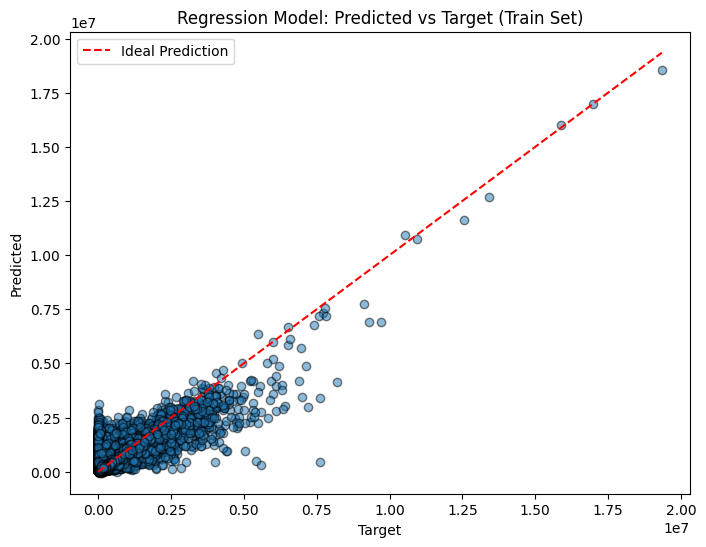

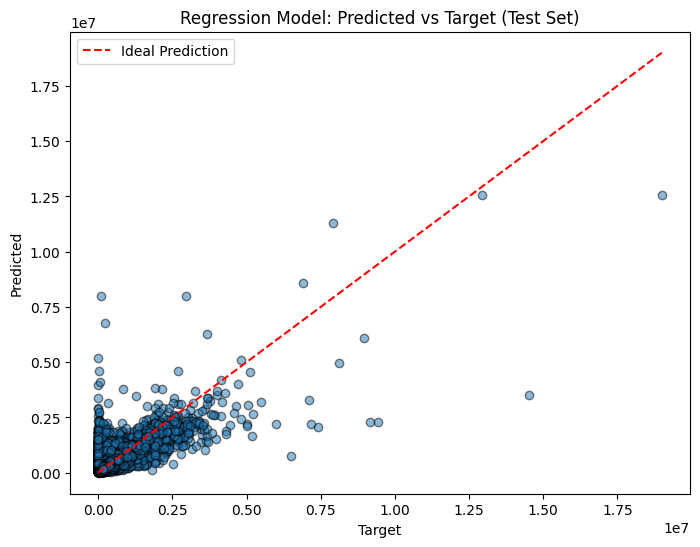

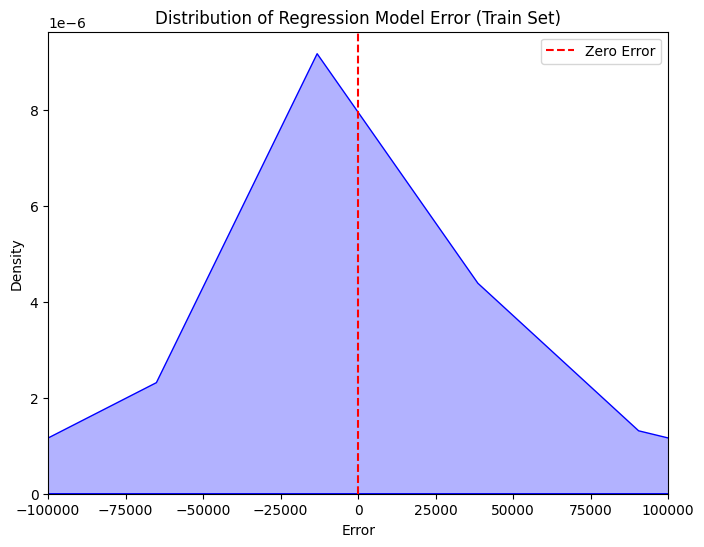

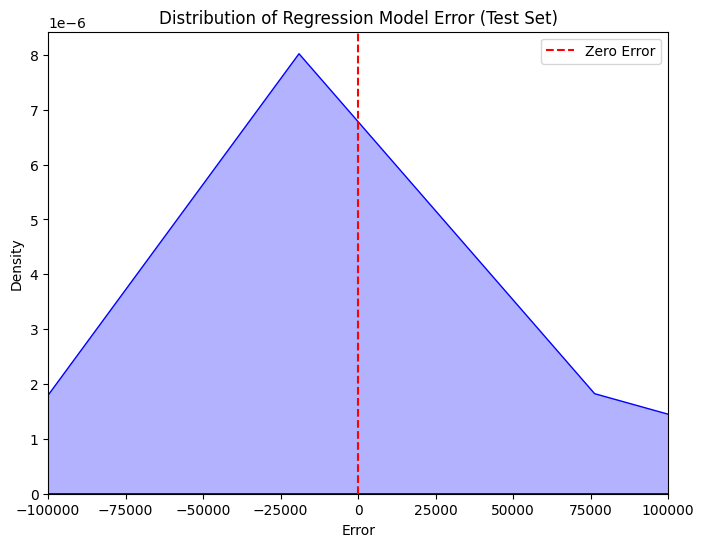

{'Train RMSE': 125751.01117309953,
 'Train MAE': 57800.461157279206,
 'Train R2': 0.7958172656257385,
 'Test RMSE': 150461.8961816822,
 'Test MAE': 59022.23383273925,
 'Test R2': 0.7241214271123441}

In [8]:
error_analysis(
    model,
    X_train,
    y_train,
    X_test,
    y_test,
    feature_names=None,
    train_model=False,
    prediction_title="Regression Model: Predicted vs Target",
    error_title="Distribution of Regression Model Error",
    xlim_min=-1 * 10**5,
    xlim_max=10**5,
)

# Analyse des Métriques et de la Dispersion des Erreurs

## 1. Performance Globale du Modèle

### Métriques sur l'Ensemble d'Entraînement
- **RMSE** : 125751.01  
  (L'erreur quadratique moyenne est relativement faible sur l'ensemble d'entraînement.)
- **MAE** : 57800.46  
  (L'erreur absolue moyenne donne une idée de l'erreur moyenne sur les prédictions.)
- **R²** : 0.7958  
  (Le modèle explique environ 79.6% de la variance des données d'entraînement.)

### Métriques sur l'Ensemble de Test
- **RMSE** : 150461.90  
  (Le RMSE est plus élevé en test, ce qui indique une légère dégradation des performances sur des données non vues.)
- **MAE** : 59022.23  
  (Les valeurs de MAE sont proches entre entraînement et test, suggérant une bonne généralisation globale.)
- **R²** : 0.7241  
  (Le modèle explique environ 72.4% de la variance sur l'ensemble de test, ce qui est satisfaisant mais montre qu'il y a encore une marge d'amélioration.)

## 2. Analyse de la Distribution des Erreurs Absolues

### Sur l'Ensemble d'Entraînement
- **Nombre d'observations** : 413441  
- **Erreur Absolue Moyenne (MAE)** : 57800.46  
- **Écart-type** : 111680.14  
- **Erreur Minimale** : 0.0052  
- **25ème Percentile** : 12932.06  
- **Médiane (50ème Percentile)** : 29732.14  
- **75ème Percentile** : 61916.01  
- **Erreur Maximale** : 7165986.90  

### Sur l'Ensemble de Test
- **Nombre d'observations** : 103361  
- **Erreur Absolue Moyenne (MAE)** : 59022.23  
- **Écart-type** : 138402.83  
- **Erreur Minimale** : 0.5165  
- **Médiane (50ème Percentile)** : 29623.37  
- **75ème Percentile** : 61808.44  
- **Erreur Maximale** : 10998277.04  

### Interprétations
- **Proximité des MAE** :  
  Les MAE proches entre entraînement et test indiquent une bonne généralisation du modèle, sans surapprentissage marqué.
  
- **Distribution Asymétrique** :  
  La médiane étant nettement inférieure à la moyenne, la distribution des erreurs est fortement asymétrique. Cela suggère la présence d'erreurs extrêmes (outliers) qui augmentent la moyenne.
  
- **Variabilité des Erreurs** :  
  L'écart-type élevé et les valeurs maximales très importantes témoignent de cas particuliers ou d'instances difficiles à prédire. Il serait utile d'identifier ces outliers afin de comprendre leur origine et éventuellement ajuster le modèle ou le prétraitement.

## 3. Analyse de la Dispersion des Erreurs et Visualisation

### Alignement avec la Prédiction Idéale
- La ligne rouge en pointillés sur les graphiques représente la prédiction parfaite (où les valeurs prédites sont égales aux valeurs réelles).
- De nombreuses prédictions se situent en dessous de cette ligne, indiquant une **sous-estimation** systématique dans plusieurs cas.

### Erreurs et Dispersion
- **Sur le jeu d'entraînement** :  
  - Les prédictions sont globalement bien alignées pour les faibles valeurs cibles.
  - La dispersion augmente pour les valeurs cibles élevées, suggérant que le modèle a plus de difficultés à estimer correctement ces valeurs.
  
- **Sur le jeu de test** :  
  - Le schéma de sous-estimation et de dispersion croissante est retrouvé.
  - La dispersion est plus marquée, ce qui pourrait expliquer la baisse du R² entre l'entraînement (0.7958) et le test (0.7241).

## 4. Conclusion de l'Analyse

Le modèle présente une bonne capacité prédictive globale avec une généralisation satisfaisante, comme en témoignent les MAE proches sur les ensembles d'entraînement et de test. Cependant, la dispersion des erreurs révèle plusieurs points importants :
- **Distribution Asymétrique et Outliers** : La médiane inférieure à la moyenne, couplée à un écart-type et à des erreurs maximales élevés, suggère la présence d'erreurs extrêmes qui pourraient influencer négativement l'évaluation globale du modèle.
- **Difficultés pour les Valeurs Élevées** : L'augmentation de la dispersion pour les valeurs cibles élevées indique que le modèle a du mal à bien estimer ces cas particuliers.

**Pistes d'Amélioration** :
- Identifier et analyser les outliers pour comprendre leur origine.
- Envisager une transformation des cibles (par exemple, une transformation logarithmique) afin de réduire la dispersion.
- Optimiser le prétraitement ou ajuster le modèle pour améliorer la précision sur les valeurs élevées.

En résumé, si le modèle affiche de bonnes performances globales, une attention particulière doit être portée aux cas extrêmes pour affiner sa robustesse et améliorer sa précision.


## Analyse des erreurs par features numeriques

On ne considère ici que les erreurs en fonctions des features numériques pour tenter de déceler les caractéristiques qui mettent le modèle en difficulté

In [21]:
def analyze_numerical_features_errors(X_test, y_test, model, feature_names, numerical_features=None, verbose=True):
    """
    Fonction pour analyser les erreurs du modèle en fonction des prédictions et des caractéristiques numériques,
    en affichant des graphiques de distribution des erreurs et des statistiques descriptives des erreurs.

    Parameters:
    -----------
    X_test : pd.DataFrame
        Ensemble de données de test.
    y_test : pd.Series or np.array
        Cibles réelles de l'ensemble de test.
    model : object
        Modèle de machine learning déjà entraîné.
    feature_names : list
        Liste des noms des caractéristiques à utiliser pour les prédictions.
    numerical_features : list, optional
        Liste des caractéristiques numériques pour lesquelles vous souhaitez analyser les erreurs.
    verbose : bool, optional
        Si True, affiche les statistiques des erreurs.

    Returns:
    --------
    None
    """
    # Prédictions calcul des erreurs
    y_test_pred = model.predict(X_test[feature_names])

    # Conversion en numpy arrays 1D
    y_test = y_test.values.ravel()
    y_test_pred = y_test_pred.ravel()


    # calcul des erreurs
    errors_test = y_test - y_test_pred
    X_test_copy = X_test.copy()
    X_test_copy["error"] = errors_test


    # --- Analyse des caractéristiques numériques et des erreurs ---
    if numerical_features:
        for feature in numerical_features:
            plt.figure(figsize=(10, 10))
             # Paramétrer les styles de seaborn
            sns.set(style="whitegrid")
            sns.scatterplot(x=feature, y="error", data=X_test_copy)
            plt.ylim(X_test_copy["error"].min() - 1000, X_test_copy["error"].max() + 1000)
            plt.title(f"Error Distribution per {feature}")
            plt.xlabel(feature)
            plt.ylabel("Error")
            plt.show()

    # --- Affichage des statistiques des erreurs ---
    if verbose:
        print("\nError Statistics:")
        print(X_test_copy["error"].describe().apply(lambda x: format(x, ".2f")))
    error_max=X_test_copy.loc[X_test_copy["error"].idxmax()]
    error_min=X_test_copy.loc[X_test_copy["error"].idxmin()]
    print("\nMax Error:")
    print(error_max)
    print("\nMin Error:")
    print(error_min)


In [19]:
numerical_features = [ col for col in X_test.columns if X_test[col].nunique() > 2 ]
numerical_features

['surface_habitable',
 'latitude',
 'longitude',
 'mois_transaction',
 'annee_transaction',
 'prix_m2_moyen_mois_precedent',
 'nb_transactions_mois_precedent']

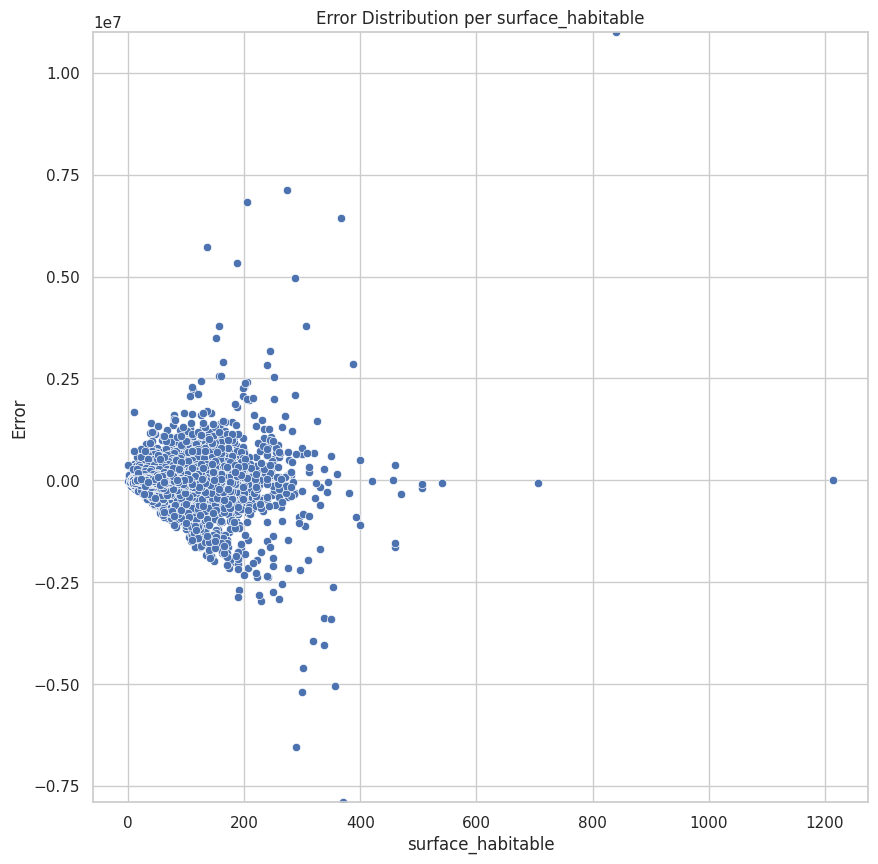

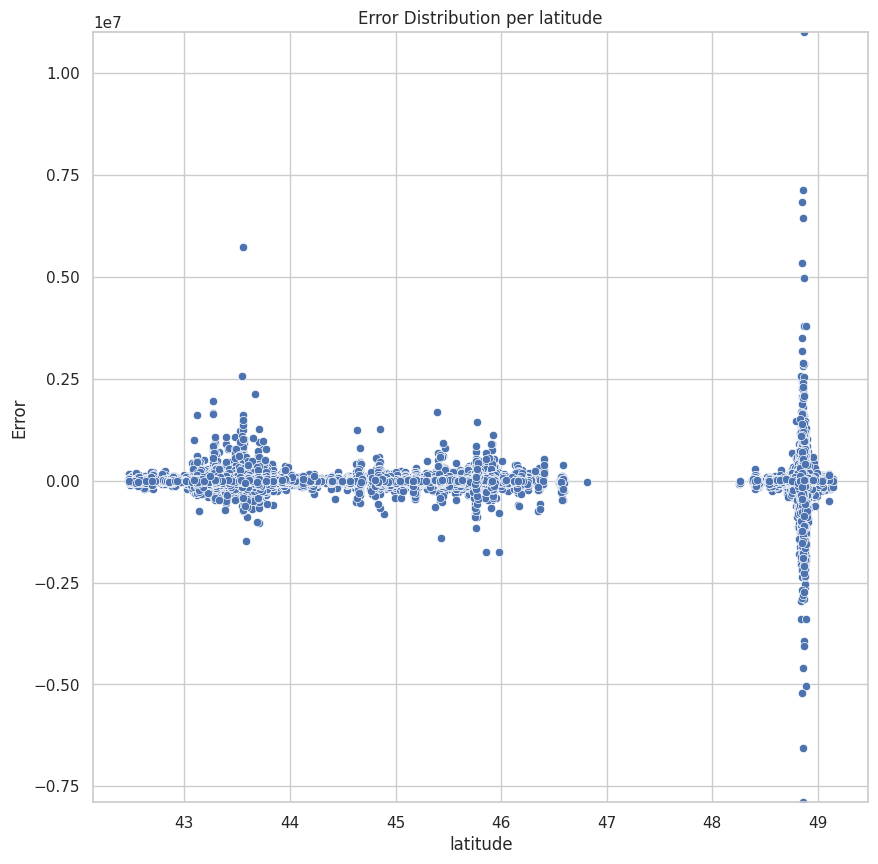

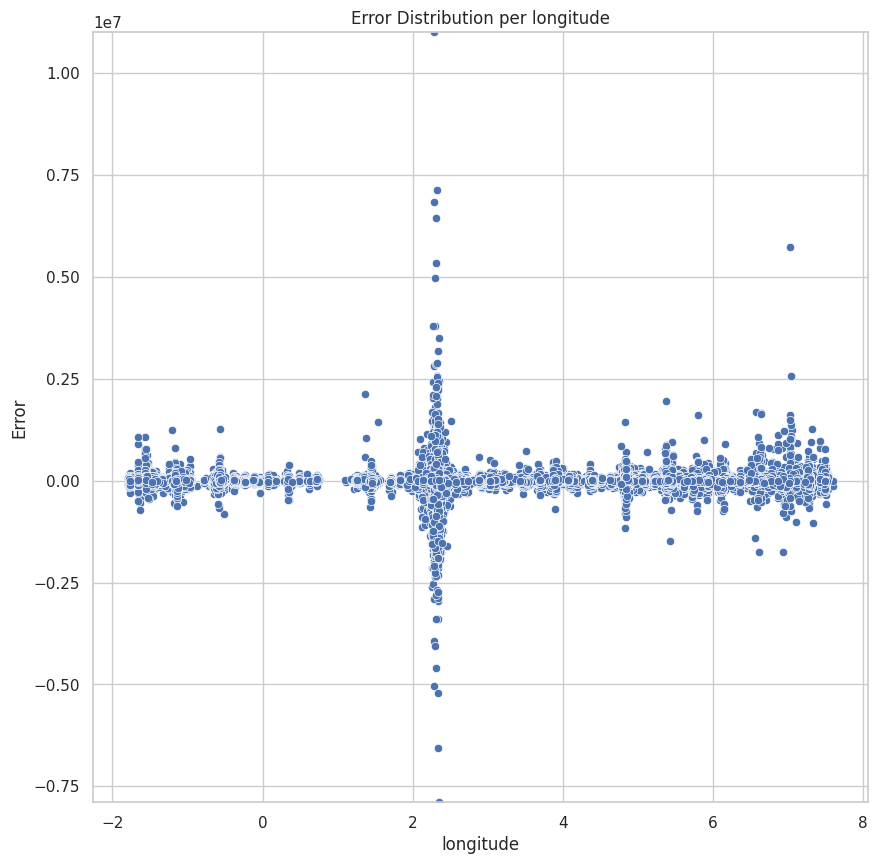

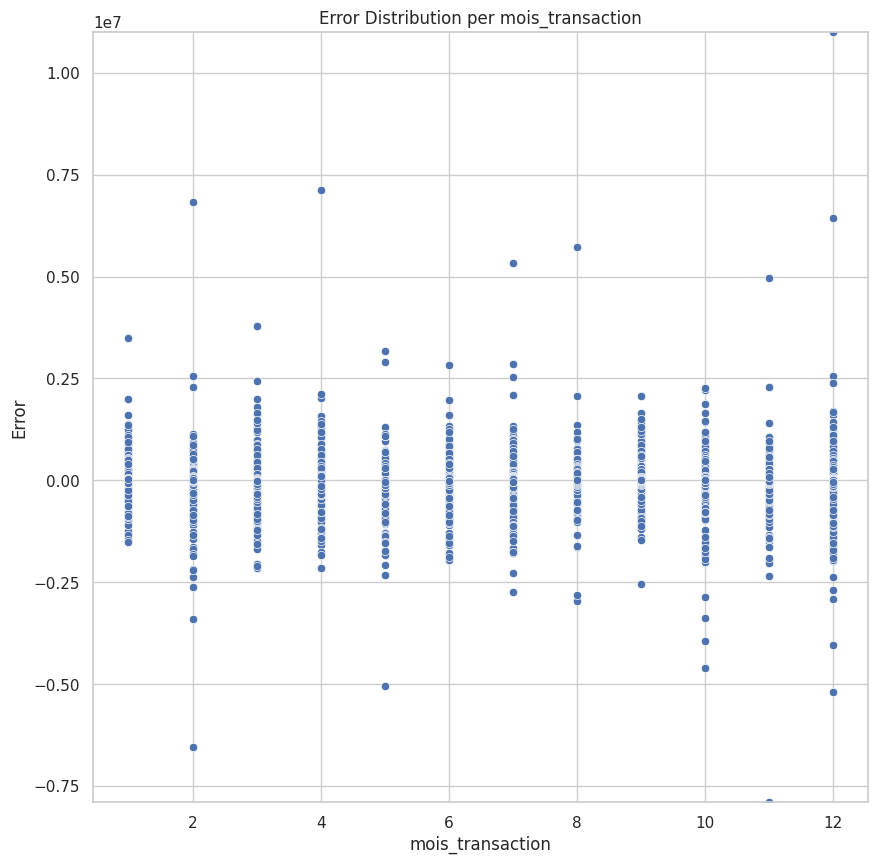

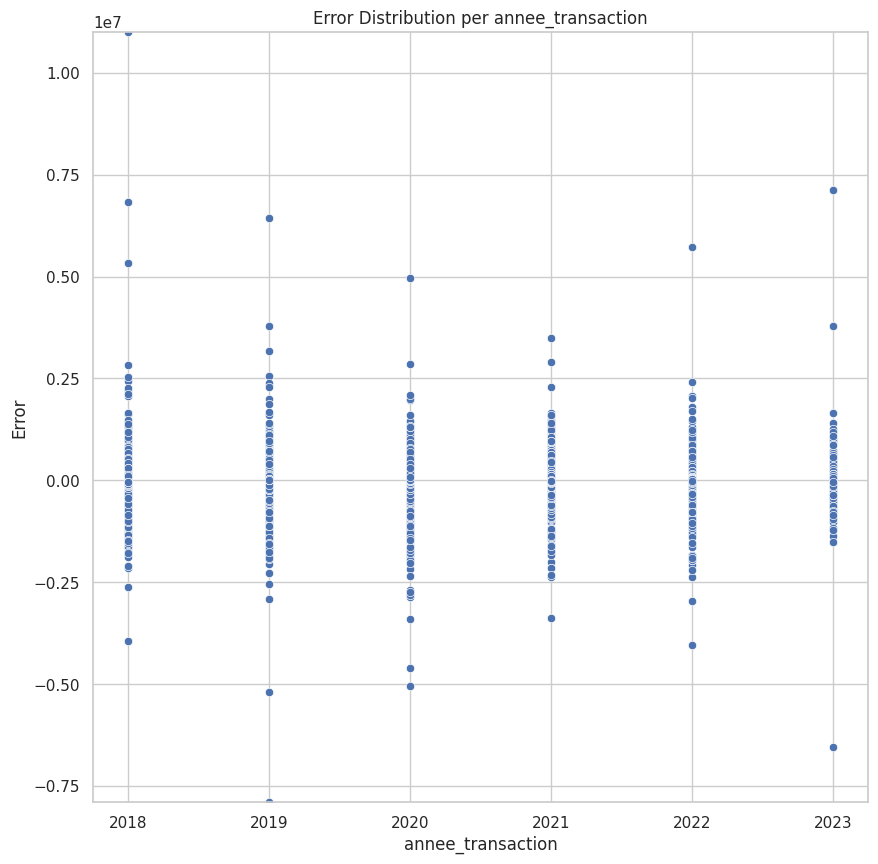

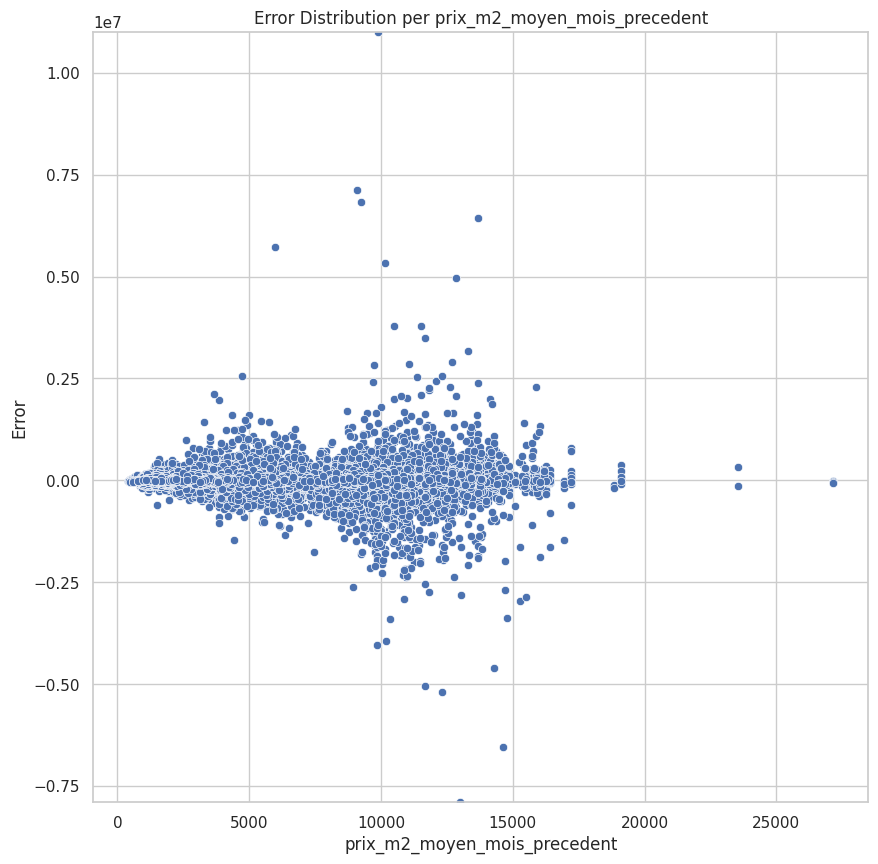

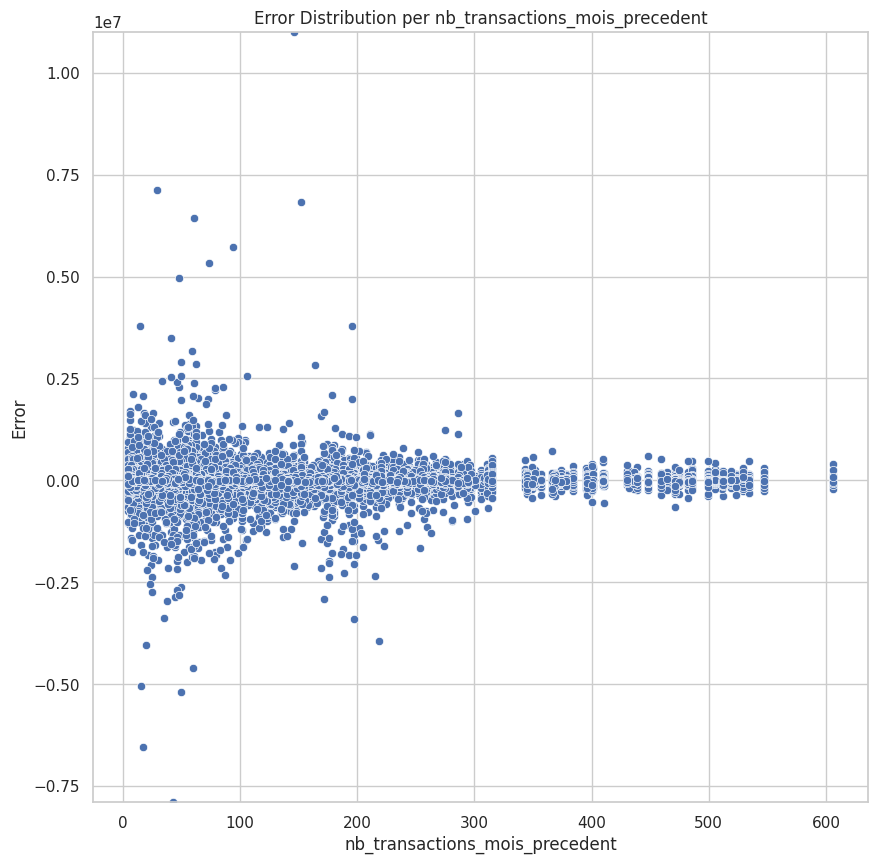


Error Statistics:
count      103361.00
mean         -333.68
std        150462.25
min      -7889430.03
25%        -29804.01
50%         -1834.67
75%         29435.88
max      10998277.04
Name: error, dtype: object

Max Error:
vefa                                     0.000000e+00
surface_habitable                        8.400000e+02
latitude                                 4.887128e+01
longitude                                2.279626e+00
mois_transaction                         1.200000e+01
annee_transaction                        2.018000e+03
prix_m2_moyen_mois_precedent             9.872220e+03
nb_transactions_mois_precedent           1.460000e+02
ville_demandee                           0.000000e+00
type_batiment_Maison                     0.000000e+00
nom_region_Nouvelle-Aquitaine            0.000000e+00
nom_region_Occitanie                     0.000000e+00
nom_region_Provence-Alpes-Côte d'Azur    0.000000e+00
nom_region_Île-de-France                 1.000000e+00
error             

In [22]:
analyze_numerical_features_errors(
    model=model,  # Votre modèle entraîné
    X_test=X_test,             # Données de test
    y_test=y_test,             # Cibles de test
    feature_names= X_train.columns.tolist(),  # Liste des noms des features utilisées pour la prédiction
    numerical_features=numerical_features,  # Liste des features numériques à analyser
    verbose=True               # Afficher les statistiques des erreurs
)

# Analyse des Erreurs du Modèle d'Estimation Immobilière

## Distribution Temporelle
Les erreurs d'estimation ne présentent pas de variations significatives selon les années ou les mois, suggérant une stabilité temporelle du modèle.

## Impact du Volume des Transactions
Une corrélation négative a été observée entre le nombre de transactions du mois précédent et l'amplitude des erreurs. Le modèle gagne en précision lorsque le volume de transactions augmente, probablement grâce à une meilleure représentativité des données d'apprentissage.

## Variations Géographiques
Une forte disparité des erreurs est constatée selon les coordonnées géographiques (latitude et longitude). La région parisienne se distingue particulièrement avec des erreurs d'estimation plus importantes, révélant les limites du modèle à appréhender les spécificités de ce marché immobilier atypique.

## Relation avec les Caractéristiques des Biens
L'analyse révèle une corrélation positive entre l'amplitude des erreurs et :
* La surface habitable
* Le prix au m²

Cette tendance confirme la difficulté du modèle à estimer précisément les biens haut de gamme, comme déjà observé dans l'analyse de la distribution globale des erreurs.

## Statistiques des Erreurs

| Métrique | Valeur |
|----------|--------|
| Nombre d'observations | 103,361 |
| Moyenne | -333.68 |
| Écart-type | 150,462.25 |
| Minimum | -7,889,430.03 |
| Premier quartile (25%) | -29,804.01 |
| Médiane (50%) | -1,834.67 |
| Troisième quartile (75%) | 29,435.88 |
| Maximum | 10,998,277.04 |

Les statistiques révèlent des valeurs extrêmes importantes (voir minimum et maximum), mais la moyenne et la médiane restent relativement modérées. L'écart entre la moyenne (-333.68) et la médiane (-1,834.67) suggère une distribution asymétrique des erreurs.


## Analyse des erreurs par catégories

Ici nous nous intéressons aux erreurs sur les variables catégorielles

In [29]:
# récupérration des encodeurs
with open("../models/encoders.pickle", "rb") as f:
    encoders = pickle.load(f)

# On récupère les encodeurs pour les variables catégorielles
type_batiment_encoder = encoders["type_batiment"]
region_encoder = encoders["nom_region"]



In [ ]:
def inverse_onehot_encoding(df, column, encoder):
    """
    Inverse le One-Hot Encoding d'une colonne pour retrouver les catégories d'origine.

    Args:
        df (pd.DataFrame): Le DataFrame contenant les colonnes encodées.
        column (str): Le nom de la colonne à inverser.
        encoder (OneHotEncoder): L'encodeur OneHotEncoder utilisé pour l'encodage.

    Returns:
        pd.DataFrame: Le DataFrame avec la colonne inversée.
    """
    # Récupérer les noms des colonnes encodées par l'encodeur
    categories = encoder.get_feature_names_out([column])

    # Vérifier que les colonnes encodées sont bien présentes dans le DataFrame
    missing_cols = [col for col in categories if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Colonnes manquantes dans le DataFrame : {missing_cols}")

    # Appliquer l'inverse_transform et convertir le résultat en 1D
    df[column] = encoder.inverse_transform(df[categories]).ravel()

    # Supprimer les colonnes One-Hot encodées
    df = df.drop(columns=categories)

    return df


In [31]:
X_test_categorical_analysis = X_test.copy()

# Inversion du One-Hot Encoding pour "type_batiment"
X_test_one_hot_inverted = inverse_onehot_encoding(
    X_test_categorical_analysis, 'type_batiment', type_batiment_encoder
)

# Inversion du One-Hot Encoding pour "nom_region"
X_test_one_hot_inverted = inverse_onehot_encoding(
    X_test_one_hot_inverted, 'nom_region', region_encoder
)

# Afficher les 5 premières lignes
print(X_test_one_hot_inverted.head())


   vefa  surface_habitable   latitude  longitude  mois_transaction  \
0     0                 33  45.748344   4.838451                 1   
1     0                 65  44.855358   0.456750                10   
2     1                 63  48.804830   2.323726                11   
3     0                 30  44.805759  -0.598314                 9   
4     0                 86  45.475106   4.532944                 7   

   annee_transaction  prix_m2_moyen_mois_precedent  \
0               2021                       5012.62   
1               2020                       1542.18   
2               2018                       4949.16   
3               2018                       3340.02   
4               2019                       1139.85   

   nb_transactions_mois_precedent  ville_demandee type_batiment  \
0                              49               0   Appartement   
1                              10               1   Appartement   
2                               8               0   A

In [32]:


def plot_error_boxplot_with_predictions(model, X_test, y_test, df,categorical_features):
    """
    Calcule les erreurs de prédiction, ajoute la colonne 'error' dans X_test,
    puis crée un boxplot des erreurs par rapport à chaque caractéristique catégorielle spécifiée.

    Parameters:
    -----------
    model : object
        Modèle de machine learning qui a été entraîné.
    X_test : pd.DataFrame
        Ensemble de test avec les caractéristiques.
    y_test : pd.Series
        Valeurs réelles pour l'ensemble de test.
    categorical_features : list
        Liste des caractéristiques catégorielles pour lesquelles un boxplot des erreurs sera tracé.
    """
    # Prédictions et calcul des erreurs
    y_test_pred = model.predict(X_test)

    # Conversion en numpy arrays 1D
    y_test = y_test.values.ravel()
    y_test_pred = y_test_pred.ravel()

    errors_test = y_test - y_test_pred
    df_copy = df.copy()
    df_copy["error"] = errors_test  # Ajout de la colonne des erreurs

    # Création des boxplots pour chaque caractéristique catégorielle
    for feature in categorical_features:
        plt.figure(figsize=(8, 6))
        sns.boxplot(x=df_copy[feature], y=df_copy["error"])
        plt.ylabel("Error")
        plt.xlabel(feature)
        plt.xticks(rotation=70)
        plt.title(f"Boxplot of Error vs {feature}")
        plt.show()


In [33]:
categorical_features_updated= [col for col in X_test_one_hot_inverted.columns if col not in numerical_features]

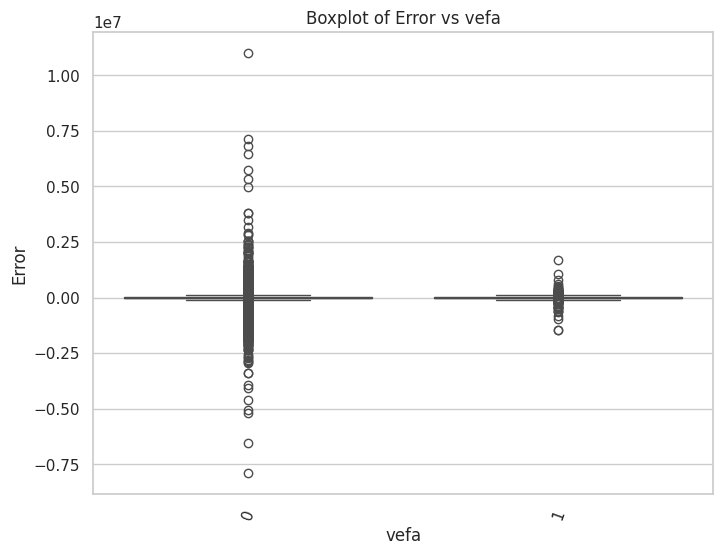

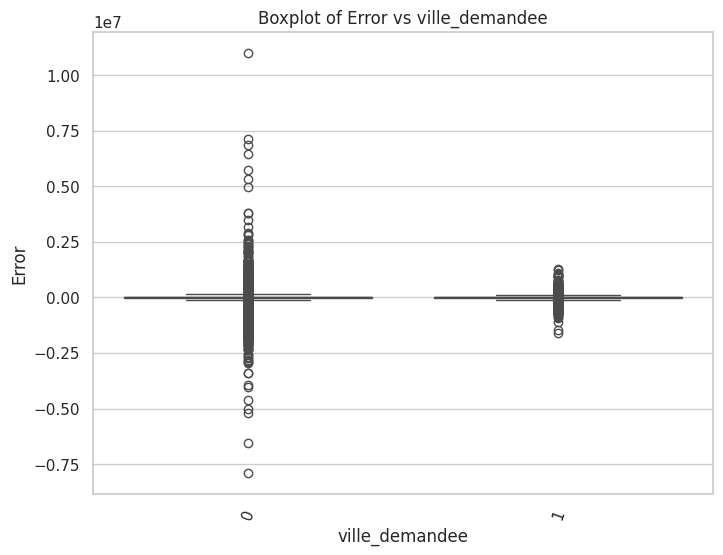

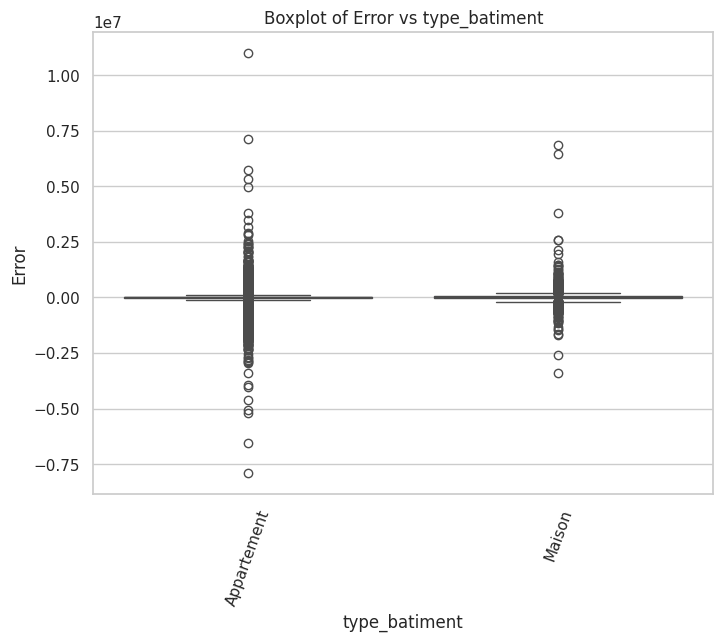

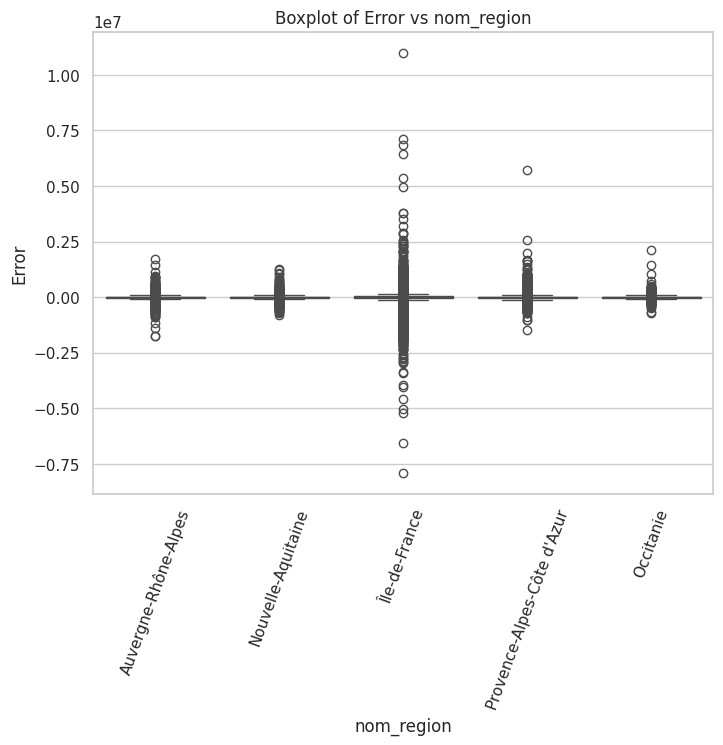

In [34]:
plot_error_boxplot_with_predictions(model, X_test, y_test,X_test_one_hot_inverted, categorical_features_updated)

## Analyse des Erreurs sur les Variables Catégorielles

L'analyse des erreurs selon les différentes caractéristiques catégorielles met en évidence plusieurs facteurs discriminants :

### Type de Vente
* Les biens hors VEFA (Vente en l'État Futur d'Achèvement) présentent des erreurs d'estimation plus importantes que les biens en VEFA
* Cette différence pourrait s'expliquer par une plus grande standardisation des prix pour les biens neufs en VEFA

### Type de Bien
* Les appartements génèrent des erreurs plus élevées que les maisons
* Cette disparité suggère que le modèle a plus de difficultés à capturer la complexité du marché des appartements, potentiellement en raison d'une plus grande hétérogénéité des caractéristiques

### Localisation
* Les biens situés en région parisienne montrent des erreurs d'estimation significativement plus importantes
* Cette observation confirme la spécificité du marché immobilier parisien et la difficulté du modèle à en saisir toutes les subtilités

### Attractivité des Villes
* Les biens situés dans des villes moins demandées présentent des erreurs plus importantes
* Ce constat suggère que le modèle performe mieux dans les zones où le marché immobilier est plus dynamique et prévisible

## Analyse des erreurs par region

Nous analysons maintenant les erreurs selon les régions

In [35]:
def plot_regression_predictions_by_category(model, X_test, y_test, df, categorical_feature, title):
    """
    Affiche des prédictions contre les cibles pour chaque valeur d'une caractéristique catégorielle.
    Crée un graphique de type 'scatter plot' pour chaque catégorie.

    Parameters:
    -----------
    model : object
        Modèle de machine learning qui a été entraîné.
    X_test : pd.DataFrame
        Ensemble de test avec les caractéristiques.
    y_test : pd.Series
        Valeurs réelles pour l'ensemble de test.
    df : pd.DataFrame
        DataFrame avec la colonne catégorielle spécifiée (par ex. 'nom_region').
    categorical_feature : str
        Le nom de la caractéristique catégorielle pour laquelle les graphiques doivent être générés.
    title : str
        Titre pour le graphique.
    """
    # Prédictions du modèle
    y_test_pred = model.predict(X_test)

    # Conversion en numpy arrays 1D
    y_test = y_test.values.ravel()
    y_test_pred = y_test_pred.ravel()

    # Ajouter la prédiction et la cible au DataFrame
    df_copy = df.copy()
    df_copy["predicted"] = y_test_pred
    df_copy["true"] = y_test

    # Générer un scatter plot pour chaque catégorie dans la caractéristique spécifiée
    unique_values = df_copy[categorical_feature].unique()

    for value in unique_values:
        # Filtrer les données pour la catégorie actuelle
        category_data = df_copy[df_copy[categorical_feature] == value]

        # Tracer le scatter plot
        plt.figure(figsize=(8, 6))
        plt.scatter(category_data["true"], category_data["predicted"], alpha=0.5, edgecolors="k")
        plt.plot(
            [min(y_test), max(y_test)],
            [min(y_test), max(y_test)],
            color="red",
            linestyle="--",
            label="Ideal Prediction",
        )
        plt.xlabel("Target")
        plt.ylabel("Predicted Target")
        plt.title(f"{title} - {categorical_feature}: {value}")
        plt.legend()
        plt.show()


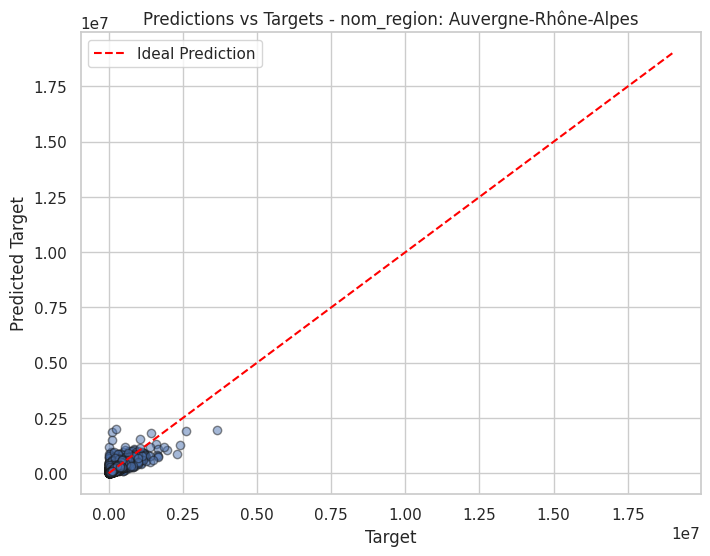

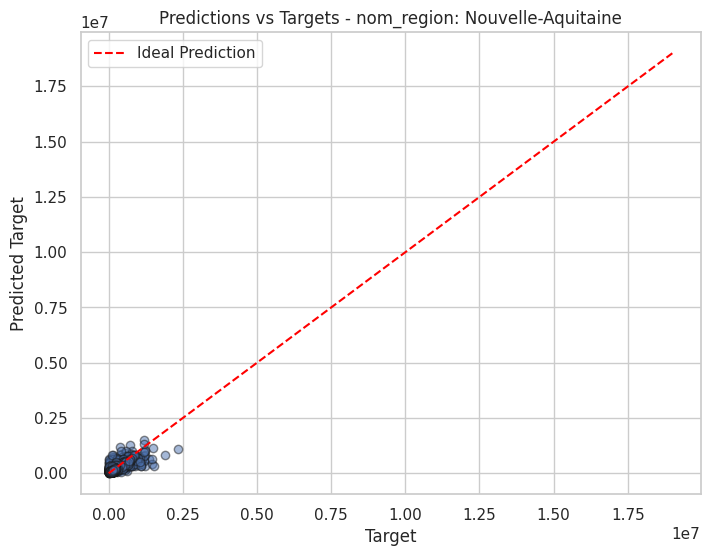

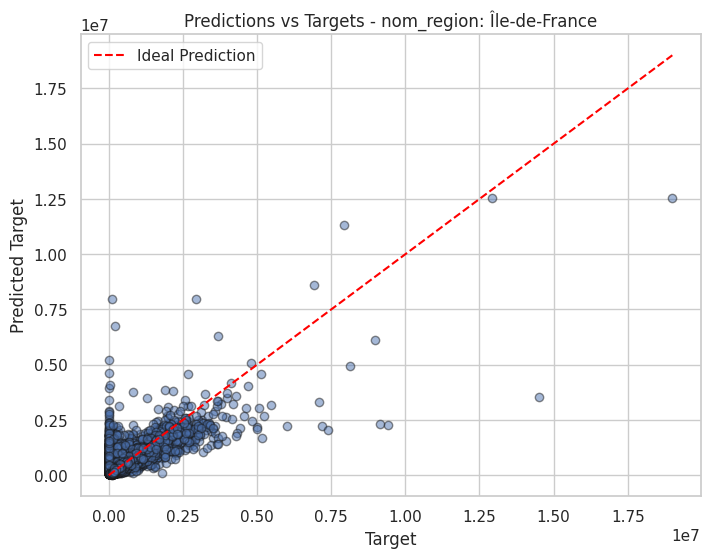

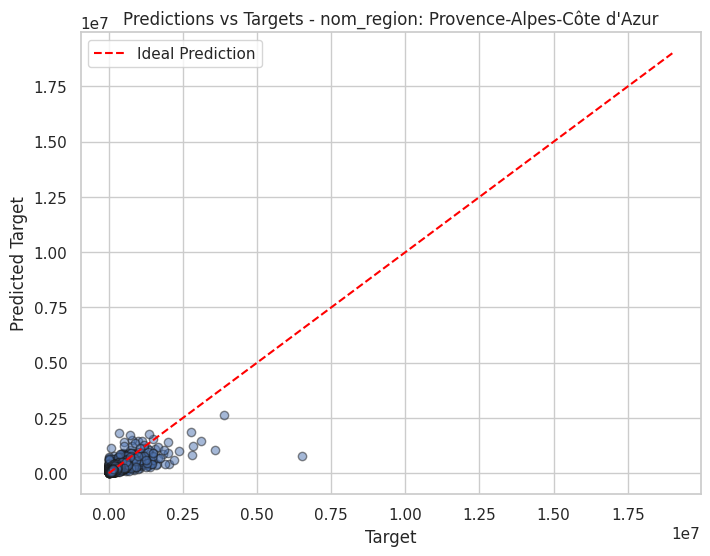

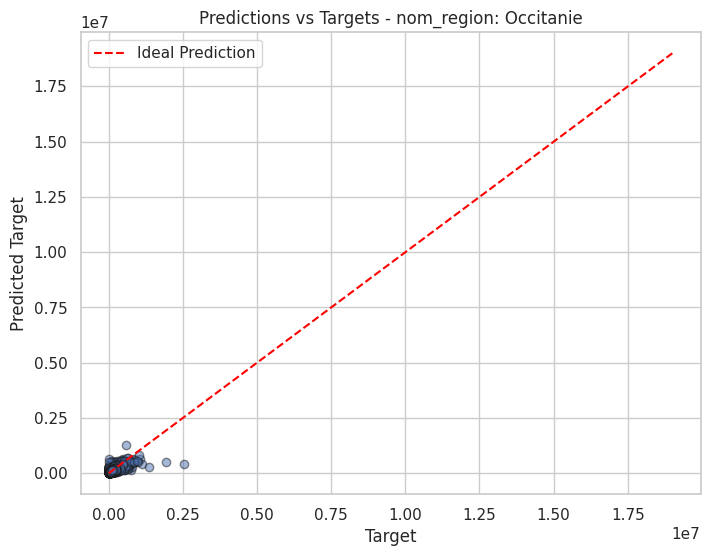

In [36]:
plot_regression_predictions_by_category(model, X_test, y_test,X_test_one_hot_inverted,categorical_feature="nom_region", title="Predictions vs Targets")

## Visualisation des valeurs SHAP globales 

Pour déceler les caractéristiques les plus importantes pour notre modèle nous calculons ici les valeurs de shapley.
Cela nous permettra de mieux expliquer le fonctionnement de notre modèle et de favoriser ainsi l'adhésion aux futurs utilisateurs.

In [37]:
train_columns = X_train.columns

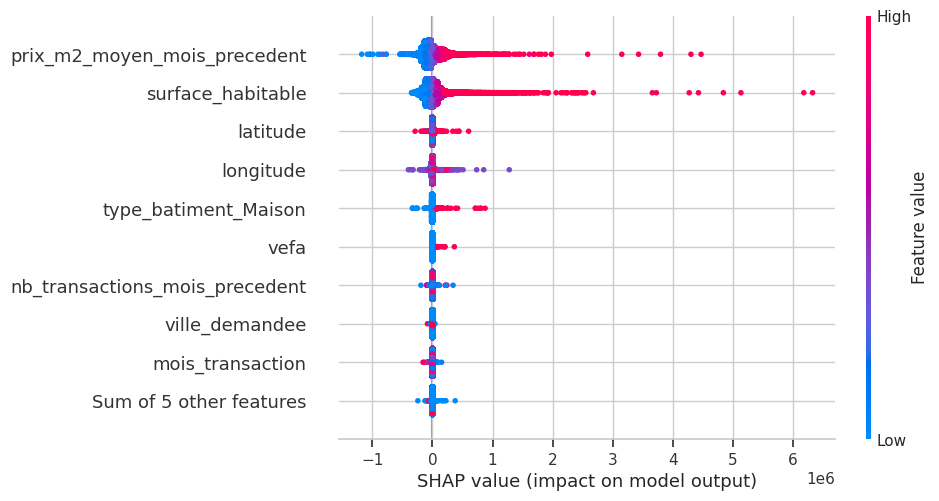

In [38]:
# Appliquer SHAP à notre modele
explainer = shap.Explainer(model)  # Créer l'explainer pour le modèle
shap_values = explainer(X_test[train_columns])  # Calculer les valeurs SHAP pour les données d'entraînement

# Visualisation des valeurs SHAP globales (importance des caractéristiques)
shap.plots.beeswarm(shap_values)

# Analyse des Valeurs SHAP

## Variables les Plus Influentes
D'après le graphique des valeurs SHAP, les caractéristiques ayant le plus d'impact sur les prédictions du modèle sont :

* **Prix au m² moyen du mois précédent** : Variable la plus influente avec des valeurs SHAP s'étendant jusqu'à 6 millions, indiquant son rôle crucial dans la détermination du prix final
* **Surface habitable** : Deuxième facteur le plus important, avec une distribution similaire des valeurs SHAP, soulignant l'importance fondamentale de la taille du bien

## Variables de Localisation
* **Latitude et Longitude** : Impact modéré mais significatif sur les prédictions, confirmant l'importance de la situation géographique
* La distribution plus étroite des valeurs SHAP pour ces variables suggère un effet plus stable et prévisible

## Caractéristiques du Bien
* **Type de bâtiment (Maison)** : Impact modéré
* **VEFA** : Influence limitée mais notable sur les prédictions
* Ces variables catégorielles ont une influence plus contenue que les variables quantitatives principales

## Variables Contextuelles
* **Nombre de transactions du mois précédent**
* **Ville demandée**
* **Mois de transaction**
Ces variables montrent des distributions de valeurs SHAP plus resserrées, indiquant une influence plus modérée et stable sur les prédictions

## Implications pour les Utilisateurs
1. Le modèle s'appuie principalement sur les métriques fondamentales (prix au m² et surface)
2. La localisation joue un rôle significatif mais secondaire
3. Les aspects contextuels (timing, demande) ont une influence plus limitée mais contribuent à la précision globale

# Conclusion Générale de l'Analyse du Modèle

## Forces et Faiblesses du Modèle
Notre modèle d'estimation immobilière présente une performance globale satisfaisante, avec des erreurs moyennes et médianes modérées (-333.68 et -1,834.67 respectivement). Cependant, l'analyse approfondie révèle plusieurs points d'attention :

### Points Forts
* Performance stable dans le temps (pas de variations significatives selon les mois/années)
* Estimation précise sur les biens standards et les marchés dynamiques
* Bonne fiabilité dans les zones à fort volume de transactions

### Points de Vigilance
* Difficulté à estimer les biens haut de gamme (surfaces importantes et prix au m² élevés)
* Performance limitée sur le marché parisien, dont les spécificités sont plus complexes à modéliser
* Erreurs plus importantes sur les appartements que sur les maisons

## Facteurs Clés d'Estimation
L'analyse SHAP confirme que le modèle s'appuie principalement sur :
1. Le prix au m² du mois précédent
2. La surface habitable
3. La localisation (latitude/longitude)

Cette hiérarchie des facteurs correspond aux fondamentaux du marché immobilier, renforçant la crédibilité du modèle.

## Recommandations d'Utilisation
1. Utiliser le modèle avec une confiance accrue pour :
  * Les biens de gamme moyenne
  * Les zones à forte activité immobilière
  * Les maisons et biens en VEFA

2. Exercer une vigilance particulière pour :
  * Les biens en région parisienne
  * Les propriétés haut de gamme
  * Les marchés peu dynamiques

Cette analyse suggère que le modèle constitue un outil fiable d'aide à la décision, tout en nécessitant une expertise humaine complémentaire pour les cas spécifiques identifiés.